<a href="https://colab.research.google.com/github/supertime1/Afib_PPG/blob/master/Afib_PPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#2. Setup Environment

In [5]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard
import numpy as np
import os
import shutil
import glob
import wfdb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model 
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_datasets as tfds
import multiprocessing
from datetime import datetime
import sklearn.metrics
import itertools
import io
print(tf.__version__)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.1.0


In [0]:
#run this cell if multiple GPUs are used
tf.debugging.set_log_device_placement(True)

In [0]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

In [0]:
tf.test.is_built_with_cuda()

# 3.1 Clean data

### 3.1 Load data

In [31]:
hd_names = []
for name in glob.glob("D:/WFDB/matched/p00/*/[0-9]*[!layout][!n].dat"):
  if os.path.getsize(name) < 17*1024:
    continue
  position = name.index('.')
  name = name[0:position] #remove the .hea part to comply the wfdb.rdrecord format
  hd_names.append(name)
print("There are total ", len(hd_names), "records that are bigger than 17kb")

There are total  27303 records that are bigger than 17kb


In [74]:
qualified_names = [] #a list of file names that contain both PPG and ECG Lead I waveforms
for name in hd_names:
  record = wfdb.rdheader(name)
  if 'I' in record.sig_name and 'PLETH' in record.sig_name and record.sig_len >= 75000: #extact only records contrains ECG lead I and PPG, and >=10min
    qualified_names.append(name)
print('There are total', len(qualified_names), 'records that have both ECG and PPG with more than 10min recording')

There are total 361 records that have both ECG and PPG with more than 10min recording


In [75]:
##use the same name for wfdb.rdrecord
##sampling freq is 125 Hz for both ECG and PPG: 
##Documentation: https://archive.physionet.org/physiobank/database/mimic3wdb/
ECG_signals = [] #create a  list to store all  ECG signals
PPG_signals = [] #create a  list to store all  PPG signals
for name in qualified_names:
  record = wfdb.rdrecord(name)

  ECG_index = record.sig_name.index('I')
  PPG_index = record.sig_name.index('PLETH')
  ECG_sig = record.p_signal.T[ECG_index]
  PPG_sig = record.p_signal.T[PPG_index]

  if np.isnan(ECG_sig).any() or np.isnan(PPG_sig).any(): ##remove list with all empty signals
    continue
  else:
    ECG_signals.append(ECG_sig)
    PPG_signals.append(PPG_sig)

print('ECG signals len:', len(ECG_signals))
print('PPG signals len:', len(PPG_signals))

ECG signals len: 214
PPG signals len: 214


In [0]:
#save the data
import pickle
#save ECG data
with open('D:/WFDB/matched/ECG_signals.pkl', "wb") as fp:
  pickle.dump(ECG_signals, fp)
#save PPG data
#with open('D:/WFDB/matched/PPG_signals.pkl', "wb") as fp:
  #pickle.dump(PPG_signals, fp)

In [0]:
with open('D:/WFDB/matched/ECG_signals.pkl', "rb") as fp:
  ECG_signals = pickle.load(fp)

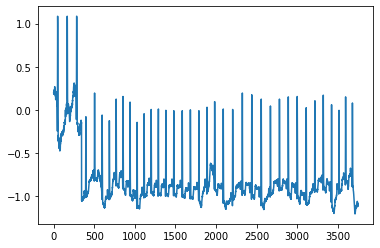

In [86]:
plt.plot(ECG_signals[0][:3750]*-1)

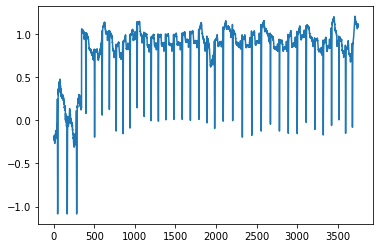

In [83]:
plt.plot(ECG_signals[0][:3750])

## Label the ECG data 

In [0]:
#1. flip signals  *-1


In [0]:
#use wfdb.resample
from wfdb import processing
for i in range(len(ECG_signals)):
  new_ECG_signals[i] = wfdb.processing.resample_sig(ECG_signals[i],125,300)

plt.plot(ECG_signals[0])
#apply filters before using DEEP-ECG to label it

In [59]:
new_freq = wfdb.processing.resample_sig(ECG_signals[1],125,300)

AttributeError: ignored

In [0]:
wfdb.rdsamp(x,)

## Data processing for PPG signals

In [0]:
##From BP paper: https://github.com/supertime1/bp-estimation-mimic3
#1. length check - remove files <1min already did when loading the data 
#2. ppg/ecg normalization - zero mean and unit variance??
#3. ppg/ecg band-pass filter - butterworth 4th order (0.5 to 8 Hz)
#4. cycle segmentation - elgendi algorithm for peak detection
#5. ppg outlier removal - hempel filter (6 samples, 3 stds)
#6. flat line and peak removal (consecutive samples with same value)

Hampel filter

In [0]:
def filter_signal(data, fs):
    % INPUT:
    % data  -> 2xN matrix where (1,:) is PPG signal and (2,:) is ABP signal, assuming that N >= 10000
    % fs    -> Sampling frequency
    % OUTPUT
    % data  -> filtered input data
    
    % Remove steep steps at the begining of the data (if there are any)
    dff = find( abs(diff(data(1,1:8000))) > 10 , 1);
    if(~isempty(dff))
        % remove the step in both ABP and PPG
        data = data(:,dff+1:end);
    end
    % check in ABP as well
    dff = find( abs(diff(data(2,1:8000))) > 400, 1);
    if(~isempty(dff))
        % remove the step in both ABP and PPG
        data = data(:,dff+1:end);
    end
    
    % In rare cases where the spike apears at the end of signal
    dff = find( abs(diff(data(1,(end-8000):end))) > 10 , 1);
    if(~isempty(dff))
        % remove the step in both ABP and PPG
        data = data(:,1:end-dff-1);
    end
    % check in ABP as well
    dff = find( abs(diff(data(2,(end-8000):end))) > 400, 1);
    if(~isempty(dff))
        % remove the step in both ABP and PPG
        data = data(:,1:end-dff-1);
    end
    
    % Flter PPG using the buttersworth filter (Bandwidth, [0.5, 8] Hz, 2-5 order)
    [b,a] = butter(4,[0.5,8]/(fs/2));  % butterworth filter
    data(1,:) = filtfilt(b,a,data(1,:)); % zero phase filter -> eliminates the phase shift that occurs when filtering
    
    % Filter ABP using Hampel filter (    median, 6 neighbour, 3x standard deviation)
    data(2,:) = hampel(data(2,:),100,5); % no parametr changes due to the effectivenes of the original
    
    
end

## Build model